In [1]:
import warnings
import datetime
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
Event = 840030016

In [2]:
MIN_ADD = datetime.timedelta(seconds = 60)
HOUR_ADD = 60 * MIN_ADD
DAY_ADD = HOUR_ADD * 24 

In [3]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

In [4]:
dfMarketData = pd.read_csv('WDODATA.csv','\t')
dfMarketData.columns = ['Date','Time','Open','High','Low','Close','TickVol','Vol','Spread']
dfMarketData['Datetime'] = dfMarketData['Date'].str.replace('.','-') + ' ' + dfMarketData['Time']
dfMarketData = dfMarketData[['Datetime','Open','High','Low','Close']]
dfMarketData['Returns'] = dfMarketData['Close'].pct_change()
dfMarketData['Datetime'] = pd.to_datetime(dfMarketData['Datetime'])
dfMarketData = dfMarketData.set_index('Datetime')
dfMarketData = dfMarketData.sort_index()
dfMarketData['RSI_2']=get_rsi(dfMarketData['Close'], 2)
dfMarketData.tail()

,Open,High,Low,Close,Returns,RSI_2
Datetime,,,,,,
2023-04-06 13:55:00,5082.0,5083.0,5081.5,5082.0,0.000098,44.810309
2023-04-06 13:56:00,5081.5,5082.5,5081.5,5082.5,0.000098,67.122028
2023-04-06 13:57:00,5082.0,5084.0,5082.0,5083.5,0.000197,87.437218
2023-04-06 13:58:00,5083.5,5083.5,5081.5,5081.5,-0.000393,25.186528
2023-04-06 13:59:00,5081.5,5082.0,5081.5,5081.5,0.000000,25.186528


In [5]:
dfEventsData = pd.read_csv('EventsData.csv')
dfEventsFromTo = pd.read_csv('EventsFromTo.csv')
dfEventsFromTo=dfEventsFromTo.set_index('EventID').T
dfEventsData['ReleaseTime'] = pd.to_datetime(dfEventsData['Datetime'])
dfEventsData['PercentChng'] = dfEventsData['ActualValue'].pct_change()
dfEventsData['DummyChng'] = 0
dfEventsData.loc[dfEventsData['PercentChng']>0, 'DummyChng'] = 1
dfEventsData.loc[dfEventsData['PercentChng']<0, 'DummyChng'] = -1
dfEventsData['Date'] = dfEventsData['ReleaseTime'].apply(lambda x: datetime.datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
dfEventsData = dfEventsData.loc[dfEventsData['ReleaseTime'] > min(dfMarketData.index),:]
dfEventsData['Datetime'] = pd.to_datetime(dfEventsData['ReleaseTime'])
dfEventsData = dfEventsData.set_index('Datetime')
dfEventsData = dfEventsData.sort_index()
dfEventsData = dfEventsData[dfEventsData['EventID']==Event][['ActualValue','PercentChng','DummyChng']]
dfEventsData = pd.merge(dfEventsData, dfMarketData[['Close','RSI_2']], how='inner', on='Datetime')
dfEventsData.columns = ['ActualValue','PercentChng','DummyChng','WdoPrice','WdoRsi2']
dfEventsData['WdoRsiBool'] = False
dfEventsData['WdoRsiBool'] = dfEventsData['WdoRsi2']>=70
dfEventsData['WdoRsiBool'] = dfEventsData['WdoRsi2']<=30
dfEventsData.tail()

,ActualValue,PercentChng,DummyChng,WdoPrice,WdoRsi2,WdoRsiBool
Datetime,,,,,,
2022-11-04 09:30:00,261.0,-0.007605,-1,5124.5,38.284897,False
2022-12-02 10:30:00,263.0,0.007663,1,5240.5,94.474322,False
2023-01-06 10:30:00,223.0,-0.152091,-1,5358.5,21.022909,True
2023-02-03 10:30:00,517.0,1.318386,1,5119.0,95.689114,False
2023-03-10 10:30:00,311.0,-0.398453,-1,5211.5,3.506310,True


In [6]:
mins_to_check_before=[1,5]
dfEventsData['WdoMaxVarAfter']=0

for mins in mins_to_check_before:
    dfEventsData[f'WdoVar{str(mins)}MinBefore']=0
    dfEventsData[f'WdoMaxVar{str(mins)}MinBefore']=0

for idx, release in dfEventsData.iterrows():
        for mins in mins_to_check_before:
            mktdata_on_release = idx
            mktdata_pre_release = mktdata_on_release - MIN_ADD * mins
            df_mktdata_pre_release = dfMarketData[(dfMarketData.index <= mktdata_on_release) & (dfMarketData.index >= mktdata_pre_release)]
            if not df_mktdata_pre_release.empty:
                release_price = -1
                dfEventsData[f'WdoVar{str(mins)}MinBefore'][idx]=df_mktdata_pre_release['Close'][-1]-df_mktdata_pre_release['Open'][0]
                dfEventsData[f'WdoMaxVar{str(mins)}MinBefore'][idx]=(max(abs(df_mktdata_pre_release['Close'][-1]-max(df_mktdata_pre_release['High'])),abs(df_mktdata_pre_release['Close'][-1]-min(df_mktdata_pre_release['Low']))))

for idx, release in dfEventsData.iterrows():
        mktdata_on_release = idx
        mktdata_after_release = mktdata_on_release + MIN_ADD * 5
        df_mktdata_release = dfMarketData[(dfMarketData.index >= mktdata_on_release) & (dfMarketData.index <= mktdata_after_release)]
        if not df_mktdata_release.empty:
            release_price = -1
            try:
                release_price = df_mktdata_release['Open'][mktdata_on_release]
            except:
                try:
                    release_price = df_mktdata_release['Close'][mktdata_on_release - MIN_ADD]
                except:
                    print('ERROR')
            dfEventsData['WdoMaxVarAfter'][idx]=(max(abs(release_price-max(df_mktdata_release['High'])),abs(release_price-min(df_mktdata_release['Low']))))

In [7]:
dfEventsData.head()

,ActualValue,PercentChng,DummyChng,WdoPrice,WdoRsi2,WdoRsiBool,WdoMaxVarAfter,WdoVar1MinBefore,WdoMaxVar1MinBefore,WdoVar5MinBefore,WdoMaxVar5MinBefore
Datetime,,,,,,,,,,,
2018-04-06 09:30:00,103.0,-0.670927,-1,3356.0,10.226061,True,7,-3,4,-4,4
2018-05-04 09:30:00,164.0,0.592233,1,3545.5,5.415927,True,13,-11,12,-9,12
2018-06-01 09:30:00,223.0,0.359756,1,3764.0,69.405780,False,11,1,8,6,9
2018-07-06 09:30:00,213.0,-0.044843,-1,3943.0,10.169889,True,17,-12,19,-10,19
2018-08-03 09:30:00,157.0,-0.262911,-1,3749.5,2.659238,True,11,-9,11,-9,11


In [8]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=1, verbose=False):
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value <= .05
    df.columns = [str(var)+'_x' for var in variables]
    df.index = [str(var)+'_y' for var in variables]
    return df

# Feature Selection

In [9]:
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile
from sklearn.feature_selection import RFECV, RFE
from sklearn import preprocessing
import shap

default_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])

In [10]:
y = 'WdoMaxVarAfter'
x = dfEventsData.columns
x=x.drop(y)

Y = dfEventsData[y]
X = dfEventsData[x]

In [11]:
corr = X.corr()
corr = corr.style.background_gradient(cmap='coolwarm')
corr

,ActualValue,PercentChng,DummyChng,WdoPrice,WdoRsi2,WdoRsiBool,WdoVar1MinBefore,WdoMaxVar1MinBefore,WdoVar5MinBefore,WdoMaxVar5MinBefore
ActualValue,1.000000,-0.871478,-0.119655,-0.118853,-0.048270,0.173704,-0.086947,0.120643,-0.043861,0.079735
PercentChng,-0.871478,1.000000,0.378265,0.138417,0.091142,-0.176651,0.116447,-0.014924,0.081465,0.028194
DummyChng,-0.119655,0.378265,1.000000,-0.054392,0.432074,-0.286877,0.311441,0.199247,0.308788,0.181876
WdoPrice,-0.118853,0.138417,-0.054392,1.000000,0.092094,-0.060871,0.057369,0.508443,-0.014643,0.555738
WdoRsi2,-0.048270,0.091142,0.432074,0.092094,1.000000,-0.896957,0.784034,0.042779,0.802013,0.033969
WdoRsiBool,0.173704,-0.176651,-0.286877,-0.060871,-0.896957,1.000000,-0.682457,0.089672,-0.694666,0.073981
WdoVar1MinBefore,-0.086947,0.116447,0.311441,0.057369,0.784034,-0.682457,1.000000,0.031342,0.939520,0.034656
WdoMaxVar1MinBefore,0.120643,-0.014924,0.199247,0.508443,0.042779,0.089672,0.031342,1.000000,-0.000039,0.983072
WdoVar5MinBefore,-0.043861,0.081465,0.308788,-0.014643,0.802013,-0.694666,0.939520,-0.000039,1.000000,-0.025490
WdoMaxVar5MinBefore,0.079735,0.028194,0.181876,0.555738,0.033969,0.073981,0.034656,0.983072,-0.025490,1.000000


In [12]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
ActualValue,57.0,79.263158,2870.456413,-20500.000000,164.000000,263.000000,431.000000,4800.000000
PercentChng,57.0,0.701255,4.081088,-3.567766,-0.403409,-0.052381,0.451820,28.243937
DummyChng,57.0,-0.228070,0.982299,-1.000000,-1.000000,-1.000000,1.000000,1.000000
WdoPrice,57.0,4768.245614,722.526730,3356.000000,3966.500000,5100.000000,5292.500000,5780.500000
WdoRsi2,57.0,38.768906,37.082898,0.167144,5.155643,21.022909,79.813843,99.451270
WdoVar1MinBefore,57.0,-2.859649,13.765172,-31.000000,-10.000000,-3.000000,2.000000,42.000000
WdoMaxVar1MinBefore,57.0,16.368421,10.929370,1.000000,8.000000,13.000000,24.000000,48.000000
WdoVar5MinBefore,57.0,-3.508772,13.210011,-32.000000,-9.000000,-4.000000,3.000000,37.000000
WdoMaxVar5MinBefore,57.0,17.421053,10.542342,3.000000,9.000000,15.000000,24.000000,48.000000


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0, shuffle=False)

## Granger Causality

In [14]:
# Granger causality
grangers_causation_matrix(dfEventsData, dfEventsData.columns)

,ActualValue_x,PercentChng_x,DummyChng_x,WdoPrice_x,WdoRsi2_x,WdoRsiBool_x,WdoMaxVarAfter_x,WdoVar1MinBefore_x,WdoMaxVar1MinBefore_x,WdoVar5MinBefore_x,WdoMaxVar5MinBefore_x
ActualValue_y,False,True,False,False,False,False,False,False,False,False,False
PercentChng_y,True,False,False,False,False,False,False,False,False,False,False
DummyChng_y,False,False,False,False,False,False,False,False,False,False,False
WdoPrice_y,True,True,False,False,False,False,False,False,False,False,False
WdoRsi2_y,False,False,False,False,False,False,False,False,False,False,False
WdoRsiBool_y,False,False,True,False,False,False,True,False,True,False,False
WdoMaxVarAfter_y,True,False,False,True,False,False,False,False,False,False,False
WdoVar1MinBefore_y,False,False,True,False,False,False,False,False,False,True,False
WdoMaxVar1MinBefore_y,False,False,False,True,False,False,True,False,False,False,False
WdoVar5MinBefore_y,False,False,False,False,False,False,False,False,False,False,False


In [15]:
# Granger causality
# label = WdoMaxVar
GrangerFeatures = ['ActualValue', 'WdoPrice']
GrangerX = X_train[GrangerFeatures]
GrangerFitted=default_pipe.fit(GrangerX, y_train)
R2Granger=GrangerFitted.score(X_test[GrangerX.columns], y_test)
print(f'R²: {R2Granger:0.4}')

R²: -0.1362


## VIF

In [16]:
def vif(dataframe):
    scaler = StandardScaler()
    xs = scaler.fit_transform(dataframe)
    vif = pd.DataFrame()
    vif["Features"] = dataframe.columns
    vif["VIF Factor"] = [variance_inflation_factor(xs, i) for i in range(xs.shape[1])]
    return vif

In [17]:
vif_df = vif(X_train).round(2)
vif_df=vif_df[vif_df['VIF Factor']<5]
vif_df

,Features,VIF Factor
2,DummyChng,2.60
3,WdoPrice,2.47


In [18]:
# VIF
# label = WdoMaxVar
VIFFeatures = ['DummyChng', 'WdoPrice']
VIFX = X_train[VIFFeatures]
VIFFitted=default_pipe.fit(VIFX, y_train)
R2VIF=VIFFitted.score(X_test[VIFX.columns], y_test)
print(f'R²: {R2VIF:0.4}')

R²: -0.06536


## SelectKBest

In [19]:
skb_method =  SelectKBest(f_regression, k=3)
skb_method.fit(X_train, y_train)
# Iterate the score
vet = []
for f, s in zip(X.columns, skb_method.scores_):
    vet.append([s,f])
vet = pd.DataFrame(vet)
vet.columns = ['Scores', 'Features']
vet.sort_values('Scores',inplace=True)
vet

,Scores,Features
0,0.053347,ActualValue
4,0.898971,WdoRsi2
2,1.558102,DummyChng
1,1.567367,PercentChng
5,2.292595,WdoRsiBool
8,6.950420,WdoVar5MinBefore
6,9.167053,WdoVar1MinBefore
3,18.531172,WdoPrice
7,88.410541,WdoMaxVar1MinBefore
9,96.533877,WdoMaxVar5MinBefore


In [20]:
# SKB
# label = WdoMaxVar
SKBFeatures = ['WdoPrice', 'WdoMaxVar1MinBefore', 'WdoMaxVar5MinBefore']
SKBX = X_train[SKBFeatures]
SKBFitted=default_pipe.fit(SKBX, y_train)
R2SKB=SKBFitted.score(X_test[SKBX.columns], y_test)
print(f'R²: {R2SKB:0.4}')

R²: 0.5229


## RFE

In [21]:
rfe_method = RFE(LinearRegression(), n_features_to_select=3, step=1)
rfe_method.fit(X_train,y_train)
min_value = min(rfe_method.ranking_)
col = [i for i, x in enumerate(rfe_method.ranking_) if x == min_value]
rfe_result=list(X.columns[col])
rfe_result

['WdoRsiBool', 'WdoVar5MinBefore', 'WdoMaxVar5MinBefore']

In [22]:
# RFE
# label = WdoMaxVar
RFEFeatures = ['PercentChng', 'WdoRsiBool', 'WdoMaxVar5MinBefore']
RFEX = X_train[RFEFeatures]
RFEFitted=default_pipe.fit(RFEX, y_train)
R2RFE=RFEFitted.score(X_test[rfe_result], y_test)
print(f'R²: {R2RFE:0.4}')

R²: -0.8847


## RFECV

In [23]:
rfecv_method = RFECV(LinearRegression(), cv=3)
rfecv_method.fit(X_train,y_train)

RFECV(cv=3, estimator=LinearRegression())

In [24]:
min_value = min(rfecv_method.ranking_)
col = [i for i, x in enumerate(rfecv_method.ranking_) if x == min_value]
rfecv_result=list(X.columns[col])
rfecv_result

['WdoMaxVar5MinBefore']

In [25]:
# RFECV
# label = WdoMaxVar
RFECVFeatures = ['PercentChng', 'WdoRsiBool', 'WdoMaxVar5MinBefore']
RFECVX = X_train[RFECVFeatures]
RFECVFitted=default_pipe.fit(RFECVX, y_train)
R2RFECV=RFECVFitted.score(X_train[RFECVFeatures], y_train)
print(f'R²: {R2RFECV}')

R²: 0.7433120776774904


## Original features

In [26]:
pipe = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
# fit/train model
OriginalFeatures=list(X_train.columns)
pipe.fit(X_train, y_train)
r2_orig = pipe.score(X_test, y_test)
print(f'R^2: {r2_orig}')

R^2: 0.30133830924974525


## Comparison

In [27]:
r2_df = pd.DataFrame({'Original Features Set': [r2_orig], 'VIF': [R2VIF], 'SelectKBest': [R2SKB], 
                      'RFE': [R2RFE], 'RFECV': [R2RFECV], 'Granger': [R2Granger]})
r2_df.index = ['R²']
r2_df = r2_df.T
r2_df.sort_values(by='R²',inplace=True)
r2_df

,R²
RFE,-0.884687
Granger,-0.136176
VIF,-0.065365
Original Features Set,0.301338
SelectKBest,0.522880
RFECV,0.743312


In [28]:
df_features= {
    'granger': GrangerFeatures,
    'vif':VIFFeatures,
    'skb': SKBFeatures,
    'rfecv':RFECVFeatures,
    'rfe':RFEFeatures,
    'original': OriginalFeatures
}
df_features

{'granger': ['ActualValue', 'WdoPrice'],
 'vif': ['DummyChng', 'WdoPrice'],
 'skb': ['WdoPrice', 'WdoMaxVar1MinBefore', 'WdoMaxVar5MinBefore'],
 'rfecv': ['PercentChng', 'WdoRsiBool', 'WdoMaxVar5MinBefore'],
 'rfe': ['PercentChng', 'WdoRsiBool', 'WdoMaxVar5MinBefore'],
 'original': ['ActualValue',
  'PercentChng',
  'DummyChng',
  'WdoPrice',
  'WdoRsi2',
  'WdoRsiBool',
  'WdoVar1MinBefore',
  'WdoMaxVar1MinBefore',
  'WdoVar5MinBefore',
  'WdoMaxVar5MinBefore']}

In [29]:
# Choice is Select K Best
Features=RFECVFeatures

# Model

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,7)
plt.style.use('fivethirtyeight')

In [31]:
ModelX_train=X_train[Features]
ModelX_test=X_test[Features]
Modely_train=y_train
Modely_test=y_test
ModelX=X[Features]
ModelY=Y

# LogReg

In [32]:
logRegPipe = Pipeline([('scaler', StandardScaler()), ('regressor', LogisticRegression())])
logRegPipe.fit(ModelX_train,Modely_train)
Modely_pred = logRegPipe.predict(ModelX_test)
mse = mean_squared_error(Modely_test, Modely_pred)
rmse = np.sqrt(mse)
df_y_test=pd.DataFrame(Modely_test)
df_y_pred=pd.DataFrame(Modely_pred)
df_y_pred.index=df_y_test.index
logRegY_df=df_y_test.merge(df_y_pred,how='inner',on='Datetime')
logRegY_df.columns=['y_test','y_pred']
logRegY_df['diff']=logRegY_df['y_test']-logRegY_df['y_pred']
logRegY_df

,y_test,y_pred,diff
Datetime,,,
2021-10-08 09:30:00,20,13,7
2021-11-05 09:30:00,15,11,4
2021-12-03 10:30:00,25,43,-18
2022-01-07 10:30:00,20,13,7
2022-02-04 10:30:00,28,11,17
2022-03-04 10:30:00,16,13,3
2022-04-01 09:30:00,16,13,3
2022-05-06 09:30:00,34,43,-9
2022-06-03 09:30:00,12,13,-1


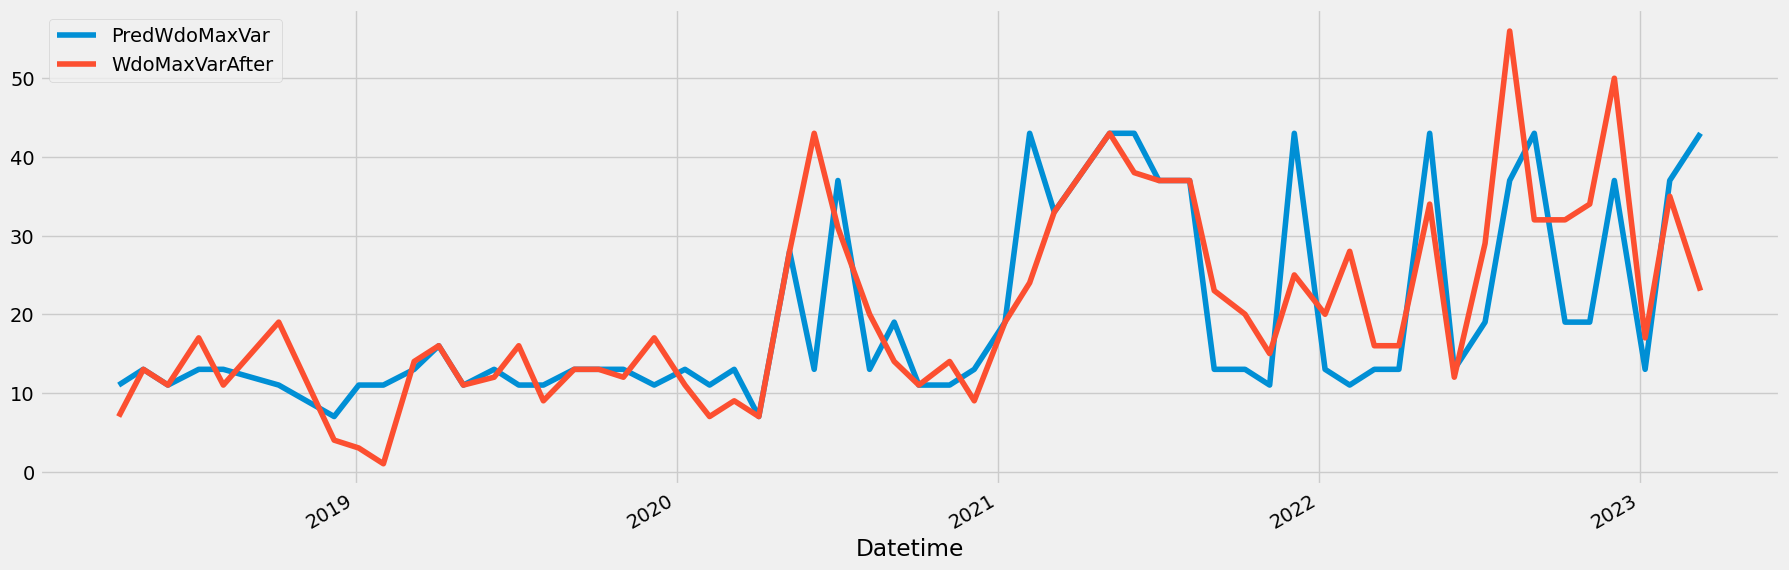

In [33]:
logRegModel_Y = pd.DataFrame(logRegPipe.predict(ModelX),columns=['PredWdoMaxVar'])
logRegModel_Y.index=ModelY.index
logRegModeldf = logRegModel_Y.merge(ModelY,how='inner',on='Datetime')
logRegModeldf.plot();

## KNeigh

In [34]:
kNeighPipe = Pipeline([('scaler', StandardScaler()), ('regressor', KNeighborsClassifier())])
kNeighPipe.fit(ModelX_train,Modely_train)
y_pred = kNeighPipe.predict(ModelX_test)
mse = mean_squared_error(Modely_test, Modely_pred)
rmse = np.sqrt(mse)
df_y_test=pd.DataFrame(Modely_test)
df_y_pred=pd.DataFrame(Modely_pred)
df_y_pred.index=df_y_test.index
kNeighY_df=df_y_test.merge(df_y_pred,how='inner',on='Datetime')
kNeighY_df.columns=['y_test','y_pred']
kNeighY_df['diff']=kNeighY_df['y_test']-kNeighY_df['y_pred']
kNeighY_df

,y_test,y_pred,diff
Datetime,,,
2021-10-08 09:30:00,20,13,7
2021-11-05 09:30:00,15,11,4
2021-12-03 10:30:00,25,43,-18
2022-01-07 10:30:00,20,13,7
2022-02-04 10:30:00,28,11,17
2022-03-04 10:30:00,16,13,3
2022-04-01 09:30:00,16,13,3
2022-05-06 09:30:00,34,43,-9
2022-06-03 09:30:00,12,13,-1


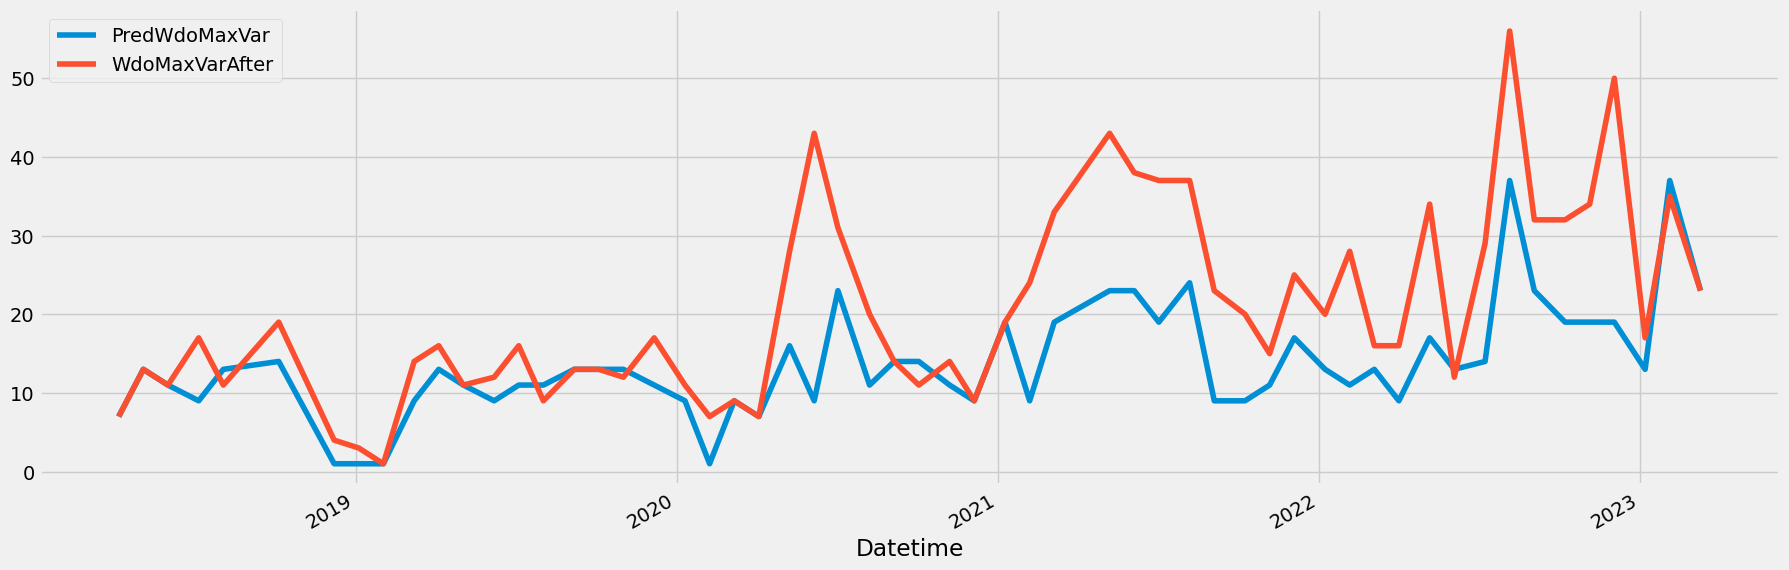

In [35]:
kNeighModel_Y = pd.DataFrame(kNeighPipe.predict(ModelX),columns=['PredWdoMaxVar'])
kNeighModel_Y.index=ModelY.index
kNeighModeldf = kNeighModel_Y.merge(ModelY,how='inner',on='Datetime')
kNeighModeldf.plot();

## DecisionTreeClassifier

In [36]:
decisionTreePipe = Pipeline([('scaler', StandardScaler()), ('regressor', DecisionTreeClassifier())])
decisionTreePipe.fit(ModelX_train,Modely_train)
y_pred = decisionTreePipe.predict(ModelX_test)
mse = mean_squared_error(Modely_test, Modely_pred)
rmse = np.sqrt(mse)
df_y_test=pd.DataFrame(Modely_test)
df_y_pred=pd.DataFrame(Modely_pred)
df_y_pred.index=df_y_test.index
decisionTreeY_df=df_y_test.merge(df_y_pred,how='inner',on='Datetime')
decisionTreeY_df.columns=['y_test','y_pred']
decisionTreeY_df['diff']=decisionTreeY_df['y_test']-decisionTreeY_df['y_pred']
decisionTreeY_df

,y_test,y_pred,diff
Datetime,,,
2021-10-08 09:30:00,20,13,7
2021-11-05 09:30:00,15,11,4
2021-12-03 10:30:00,25,43,-18
2022-01-07 10:30:00,20,13,7
2022-02-04 10:30:00,28,11,17
2022-03-04 10:30:00,16,13,3
2022-04-01 09:30:00,16,13,3
2022-05-06 09:30:00,34,43,-9
2022-06-03 09:30:00,12,13,-1


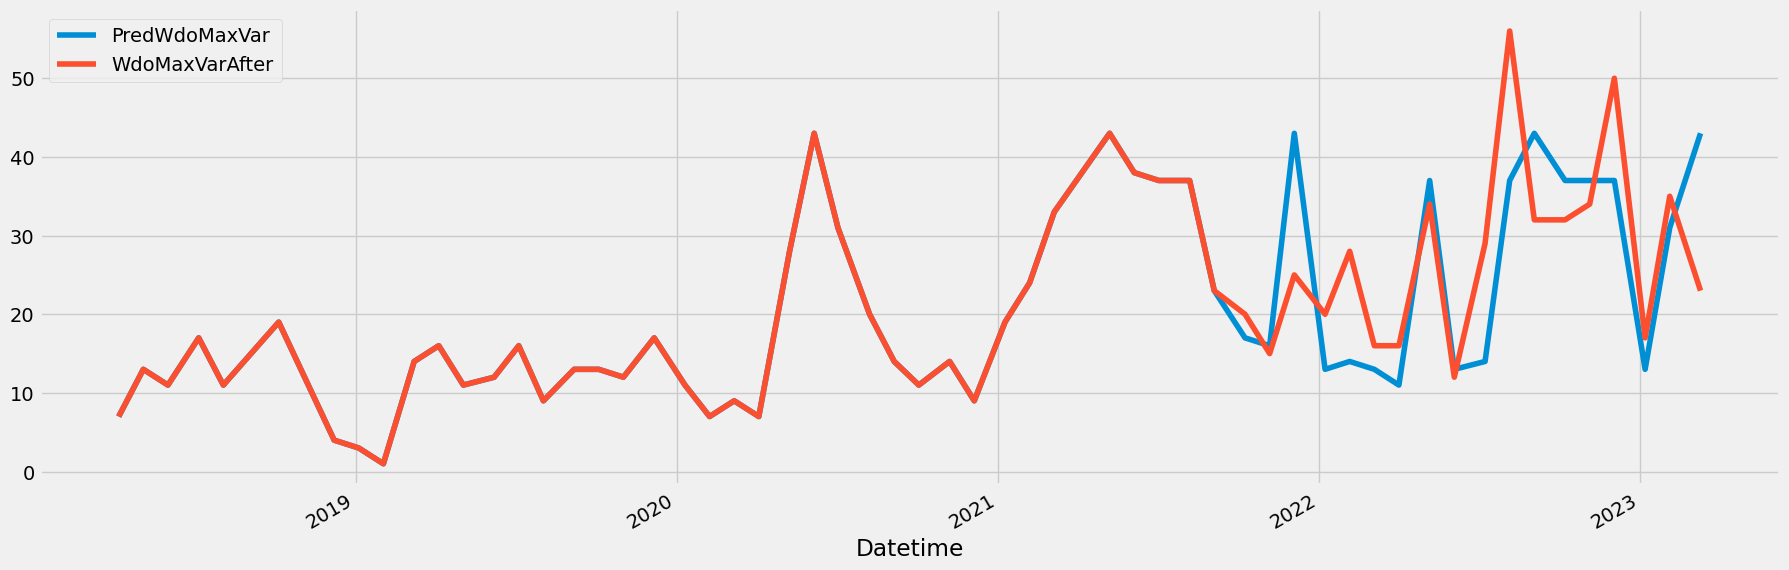

In [37]:
decisionTreeModel_Y = pd.DataFrame(decisionTreePipe.predict(ModelX),columns=['PredWdoMaxVar'])
decisionTreeModel_Y.index=ModelY.index
decisionTreeModeldf = decisionTreeModel_Y.merge(ModelY,how='inner',on='Datetime')
decisionTreeModeldf.plot();

In [38]:
Features

['PercentChng', 'WdoRsiBool', 'WdoMaxVar5MinBefore']

In [48]:
decisionTreePipe.predict(pd.DataFrame(
    {
        'PercentChng': .300, 
        'WdoRsiBool': True, 
        'WdoMaxVar5MinBefore': 14
    }, index=[0]))

array([16], dtype=int64)